In [30]:
''' Creation: 2021.09.12
    Last update: 2021.10.10
    
    User specific paths definition
    
    '''

# Standard library imports
from collections import Counter
import os
from pathlib import Path

# 3rd party import
import pandas as pd

#Internal import 
import PVcharacterization_Utils as pv

choose_files = False # Note to be programmed !!!

root = Path.home()

if choose_files :
    datafiles_list = pv.select_files()
else:
    data_folder = pv.select_data_dir(root)
    datafiles_list = list(Path(data_folder).rglob("*.csv"))

list_files_descp = [pv.parse_filename(str(file)) for file in datafiles_list]
file_check = True
list_multi_file = []
for file,frequency in Counter([os.path.basename(x) for x in datafiles_list]).items(): # Check the the uniqueness of a file name
    if frequency>1:
        list_multi_file.append(file)
        file_check = False
if not file_check:
    raise Exception(f"The file(s) {' ,'.join(list_multi_file)} has(have) a number of occurrence greater than 1.\nPlease correct before proceeding")

    
df_files_descp  = pd.DataFrame(list_files_descp)
list_modules = df_files_descp['name'].unique()

database_path = Path(os.path.dirname(datafiles_list[0])) / Path(pv.DATA_BASE_NAME)

pv.df2sqlite(df_files_descp, file=database_path, tbl_name=pv.DATA_BASE_TABLE)

print(f'{len(datafiles_list)} files was detected.\ndf_files_descp and the data base table {pv.DATA_BASE_TABLE} are built')

110 files was detected.
df_files_descp and the data base table PV_descp are built


In [31]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    
    '''
# Standard library imports
import os

#Internal import 
import PVcharacterization_Utils as pv

name_select = pv.Select_items(list_modules,'Select the modules',mode = 'multiple') # Coherence de nomencaclure ente modules
irr_select = [200,400,600,800,1000,2000,4000]
trt_select = ["T0", "T1", "T2", "T3", "T4"]

querries = pv.sieve_files(irr_select,trt_select,name_select,database_path)
list_files_name = [os.path.splitext(os.path.basename(x))[0] for x in querries]
list_files_name.sort()

df_files_descp_copy = df_files_descp

df_files_descp_copy.index = [os.path.basename(x).split('.')[0] for x in df_files_descp_copy['file_full_path'].tolist()]
df_files_descp_copy = df_files_descp_copy.loc[:,['irradiance','treatment','name'] ]

res = [pv.data_parsing(querry,parse_all=False).meta_data for querry in querries]
df_meta = pd.DataFrame.from_dict(res)
df_meta.index = df_meta['ID']
list_df_meta_index = list(df_meta.index)
list_df_meta_index .sort()

flag_name = True
list_error_name = []
for  name in zip(list_files_name ,list_df_meta_index):
    if name[0] != name[1]:
        list_error_name.append(name[0])
        flag_name = False
    if not flag_name:
        raise Exception(f"An issue with IDs has been detected with file(s) {' ,'.join(list_error_name)}.\n Please correct before proceeding")

df_meta = df_meta.loc[:,pv.USED_COLS] # keep only USED_COLS defined in PVcharacterization_GUI.py

df_meta = pd.merge(df_meta,df_files_descp_copy,left_index=True, right_index=True) # add column

pv.df2sqlite(df_meta, file=database_path, tbl_name=pv.DATA_BASE_TABLE_EXP) # For future uses.

df_meta.head(30)

,Title,Voc,Isc,Rseries,Rshunt,Pmax,Vpm,Ipm,Fill Factor,irradiance,treatment,name
QCELLS901719162417702739_0200W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0200W,37.7107,2.09860,1.00173,670.589,64.6488,32.4177,1.99424,0.81689,200,T0,QCELLS901719162417702739
QCELLS901719162417702739_0200W_T1,PERC_Q-PEAK DUO-G6_6x10 M2 0200W,37.5880,2.09715,0.97858,596.547,64.3834,32.3594,1.98963,0.81676,200,T1,QCELLS901719162417702739
QCELLS901719162417702739_0200W_T2,PERC_Q-PEAK DUO-G6_6x10 M2 0200W,37.5153,2.05749,1.02220,554.722,62.8252,32.3641,1.94120,0.81393,200,T2,QCELLS901719162417702739
QCELLS901719162417702739_0400W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0400W,38.8225,4.15992,0.58091,475.531,131.575,33.1697,3.96673,0.81471,400,T0,QCELLS901719162417702739
QCELLS901719162417702739_0400W_T1,PERC_Q-PEAK DUO-G6_6x10 M2 0400W,38.6942,4.16060,0.63060,326.482,131.097,33.0336,3.96859,0.81431,400,T1,QCELLS901719162417702739
QCELLS901719162417702739_0400W_T2,PERC_Q-PEAK DUO-G6_6x10 M2 0400W,38.6399,4.07795,0.62856,332.133,127.841,32.9232,3.88300,0.81132,400,T2,QCELLS901719162417702739
QCELLS901719162417702739_0600W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0600W,39.463,6.23739,0.47913,286.277,199.009,33.4542,5.94871,0.80850,600,T0,QCELLS901719162417702739
QCELLS901719162417702739_0600W_T1,PERC_Q-PEAK DUO-G6_6x10 M2 0600W,39.3467,6.23690,0.44284,204.517,198.122,33.1610,5.97454,0.80733,600,T1,QCELLS901719162417702739
QCELLS901719162417702739_0600W_T2,PERC_Q-PEAK DUO-G6_6x10 M2 0600W,39.2665,6.11033,0.45993,223.354,193.344,33.3109,5.80422,0.80582,600,T2,QCELLS901719162417702739
QCELLS901719162417702739_0800W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0800W,39.9344,8.303,0.36970,214.915,265.737,33.6104,7.90638,0.80143,800,T0,QCELLS901719162417702739


In [32]:
''' Creation: 2021.10.09
    Last update: 2021.10.09
    
    Interactive choice of the treatment differences
    
    '''

# Standard library imports
from itertools import combinations

if len(name_select)>2: raise Exception("Sorry, the number of modules must be <=2 ") 
list_setup = []
name =[]
if len(name_select)==2:
    for x in df_meta[['name','treatment','irradiance']].groupby('name'):
        name.append(x[0] )
        list_setup.append(set(zip(x[1]['treatment'].tolist(), x[1]['irradiance'].tolist())))
    if list_setup[1] - list_setup[0]:
        raise Exception(f'Cannot compare {name[0] } and {name[1]}')

list_treatments = pd.unique(df_meta['treatment'])

if len(list_treatments)==1: raise Exception("Sorry, the number of treatments must be >1 ") 

list_combinations = list(combinations(list_treatments,2))

list_diff = pv.Select_items(list_combinations,
                            'Select the difference',
                            mode = 'multiple')
list_diff = [(x[1],x[0]) for x in list_diff]

    

WARNING parameter trarmiz will be ignored
WARNING parameter bidon will be ignored


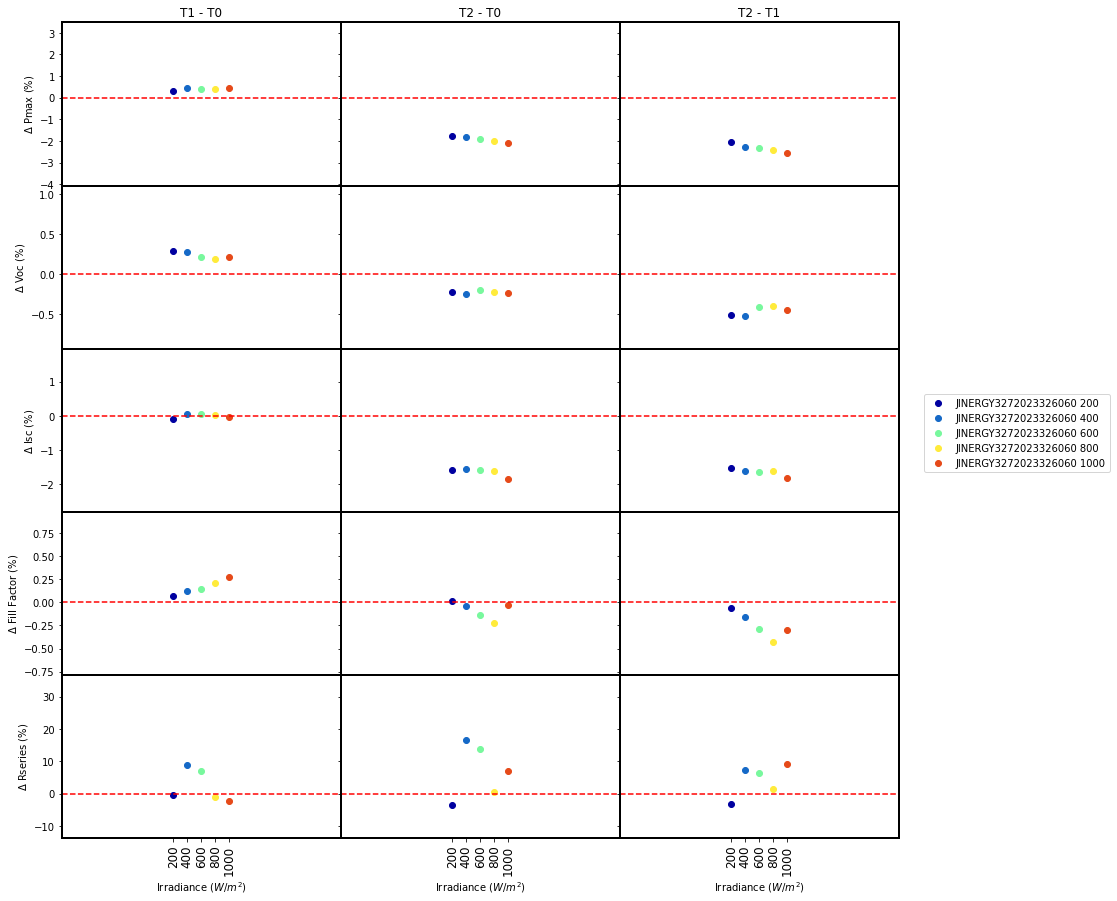

In [22]:
''' Creation: 2021.09.19
    Last update: 2021.10.09
    
    Plotting of parameters evolution.
    
    '''

#Internal import 
import PVcharacterization_Utils as pv

params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']
params_copy = list(params)
unkown_params = set(params_copy).difference(set(pv.USED_COLS))
for unknow_param in unkown_params:
    print(f'WARNING parameter {unknow_param} will be ignored')
    params.remove(unknow_param)
    
list_modules = pd.unique(df_meta['name'])          # List of modules name (ID)
pv.plot_params(params,list_modules,df_meta,list_diff = list_diff)


In [ ]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of I/V curves.
    
    '''

# 3rd party import
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv

irr_select = [1000]
name_select = ["JINERGY3272023326035",]
trt_select = ["T0","T1","T2"]

querries = pv.sieve_files(irr_select,trt_select,name_select,database_path)

for i, res in enumerate([pv.data_parsing(querry).IV0 for querry in querries]):
    plt.plot(res['Voltage'],res['Current'],label=trt_select[i])
    plt.scatter(res['Voltage'][::50],res['Current'][::50],s=10)
    plt.xlabel(res.columns[0] +'[V]')
    plt.ylabel(res.columns[1] +'[A]')
    plt.title(f'Irradiation: {str(irr_select[0])} {pv.PARAM_UNIT_DIC["IrrCorr"]}')
    
plt.legend()
plt.show()

    

In [ ]:
import sqlite3
from string import Template

trt_select = ['T0']
name = ['DINERGY3272023326035']
conv2str = lambda list_: str(tuple(list_)).replace(",)", ")")

conn = sqlite3.connect(database_path)
cur = conn.cursor()

querry_d = Template(
    """SELECT Pmax, irradiance
       FROM $table_name 
       WHERE
       treatment IN $trt_select
       AND name IN $name
                   """
)

cur.execute(
    querry_d.substitute(
        {
            "table_name": pv.DATA_BASE_TABLE_EXP,
            "trt_select": conv2str(trt_select),
            "name": conv2str(name)
        }
    )
)

res = cur.fetchall()
Pmax = [float(x[0]) for x in res]
irradiance = [float(x[1]) for x in res]
cur.close()
conn.close()
Pmax, irradiance